In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import glob
import os
import matplotlib.patches as mpatches


ERROR 1: PROJ: proj_create_from_database: Open of /nesi/project/niwa00018/queenle/ml_env_v2/share/proj failed


In [2]:
error_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/compute_metrics/results/image_errors'
plot_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/plots/image_errors'
final_figure_dir = '/nesi/project/niwa00018/queenle/ML_emulator_temporal_sampling_experiments/plotting/final_figures'


error_df = pd.read_csv(f'{error_dir}/coarsened_image_errors_epochs_220-225-230.csv').drop('Unnamed: 0',axis=1)
#error_df = pd.read_csv(f'temporal_experiment_errors_epochs_120-125-130.csv').drop('Unnamed: 0',axis=1)

In [3]:
def create_figure(fig_width=12, fig_height=16, hspace_between_groups=0.6, inner_hspace=0.1, inner_wspace=0.05):
    """
    Creates a matplotlib figure with 4 rows and 2 columns of subplots.
    - Rows 0–1 are tightly grouped.
    - Rows 2–3 are tightly grouped.
    - A space is added between the two row groups.
    - Minimal space between columns.
    - Y-axis tick labels shown only on the left column.
    - X-axis tick labels shown only on the second and fourth rows (i.e., rows 1 and 3).
    
    Returns:
        fig: The created matplotlib figure.
        axs: A 4x2 list of Axes objects: axs[row][col]
    """
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    fig.subplots_adjust(top=0.78)
    
    outer_gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace=hspace_between_groups)

    top_gs = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=outer_gs[0], hspace=inner_hspace, wspace=inner_wspace
    )
    bottom_gs = gridspec.GridSpecFromSubplotSpec(
        2, 2, subplot_spec=outer_gs[1], hspace=inner_hspace, wspace=inner_wspace
    )
    
    axs = [[None for _ in range(2)] for _ in range(4)]  # 4 rows × 2 columns

    for i in range(2):  # rows 0 and 1
        for j in range(2):
            ax = fig.add_subplot(top_gs[i, j])
            axs[i][j] = ax

            # Y-axis ticks only on left column
            if j == 1:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # X-axis ticks only on second row
            if i != 1:
                ax.set_xticklabels([])
    
    for i in range(2):  # rows 2 and 3
        for j in range(2):
            ax = fig.add_subplot(bottom_gs[i, j])
            axs[i + 2][j] = ax

            if j == 1:
                ax.set_yticklabels([])
                ax.set_ylabel('')

            # X-axis ticks only on last row
            if i != 1:
                ax.set_xticklabels([])
                
    fig.text(0.5, 0.8, "1985-2004 Climatology", ha='center', va='bottom', fontsize=22, fontweight='bold')
    fig.text(0.5, 0.39, "CC Signal", ha='center', va='bottom', fontsize=22, fontweight='bold')

    return fig, axs

#create_figure()

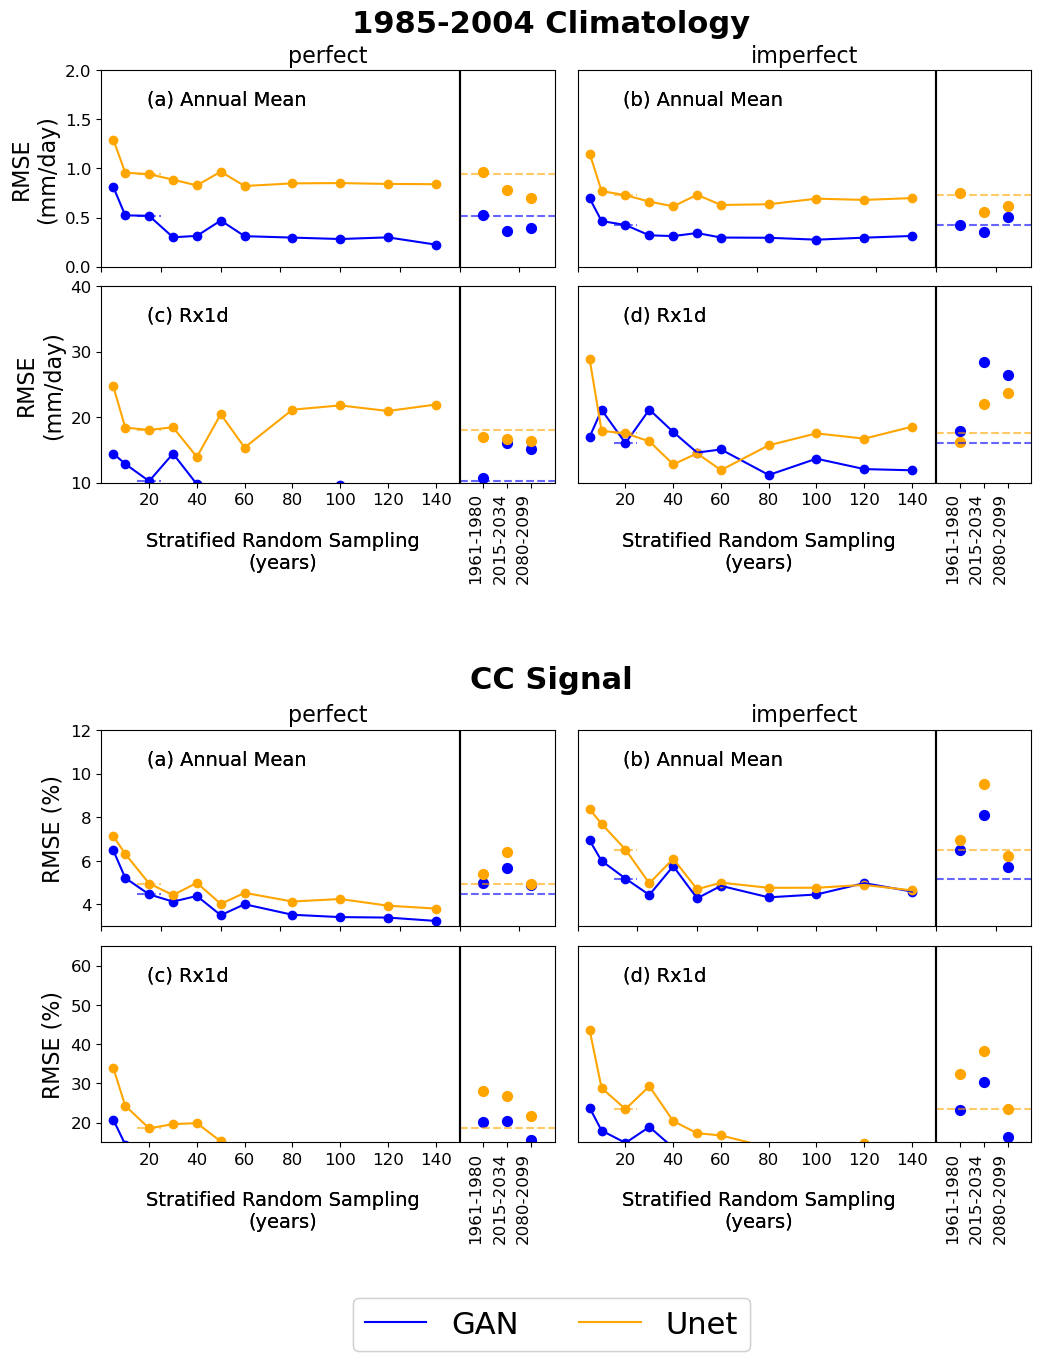

In [5]:
'''
RMSE 2 metrics - annual_mean, rx1d
'''


climo_metric_range = {'annual_mean':[0,2],'DJF_mean':[0,2],'JJA_mean':[0,2.3],'rx1d':[10,40],'total_max':[20,200]}
cc_metric_range = {'annual_mean':[3,12],'DJF_mean':[5,25],'JJA_mean':[5,15],'rx1d':[15,65],'total_max':[40,250]}

markers = ['*','s','o']
colors = {'GAN':'blue','unet':'orange'}
capitalized = {'GAN':'GAN','unet':'Unet','rx1d':'Rx1d','annual_mean':'Annual Mean',\
               'DJF_mean':'DJF Mean','JJA_mean':'JJA Mean','total_max':'Total Max'}

region = 'whole region'

x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}

subplot_labels = [['(a)','(b)'],
                 ['(c)','(d)'],
                 ['(e)','(f)'],
                 ['(g)','(h)']]


coarsen_method = 'mean'
epochs = '220-225-230-average' # ['220','230','']
error_df = pd.read_csv(f'{error_dir}/coarsened_image_errors_epochs_220-225-230.csv').drop('Unnamed: 0',axis=1)

# [230,225,220,'220-225-230-average']
for epoch in ['220-225-230-average']:#230,225,220,
    
    fig,axs_all = create_figure()
    
    if epoch == '220-225-230-average':
        epoch_df = error_df
    else:
        epoch_df = error_df[error_df['epoch']==epoch]

    for p,period in enumerate(['1985_2004','CC_signal']):#'2080_2099',

        if p == 0:
            axs = [axs_all[0],axs_all[1]]
        else:
            axs = [axs_all[2],axs_all[3]]

        df = epoch_df[epoch_df['GCM']!='ACCESS-CM2']
        df = df[df['error type']=='RMSE']
        df = df[df['error period']==period]
        df = df[df['coarsen_method']==coarsen_method]

        for i,metric in enumerate(['annual_mean','rx1d']):#total_max

            metric_df = df[df['metric']==metric]

            for j,framework in enumerate(['perfect','imperfect']):

                framework_df = metric_df[metric_df['framework']==framework]

                for ml_type in ['GAN','unet']:

                    ml_type_df = framework_df[framework_df['model_type']==ml_type]

                    gcm_dfs = []
                    for gcm  in ['EC-Earth3','NorESM2-MM']:
                        gcm_result = ml_type_df[ml_type_df['GCM']==gcm].groupby('sampling_n').mean(numeric_only=True)[region]
                        gcm_dfs.append(gcm_result)

                    mean = sum(gcm_dfs)/2

                    results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
                    results_n.index = results_n.index.astype(int)
                    results_n = results_n.sort_index()

                    results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

                    # PLOTTING
                    # dashed line at 20-year random sampling
                    random_20_val = results_n[20]
                    axs[i][j].hlines(random_20_val,15,25,color=colors[ml_type],linestyle='--',alpha=0.6)
                    axs[i][j].hlines(random_20_val,150,190,color=colors[ml_type],linestyle='--',alpha=0.6)#,label=f'{ml_type} random 20-year sample')
                    
                    # n samples
                    x = [int(v) for v in results_n.index]
                    axs[i][j].scatter(x,results_n,color=colors[ml_type])
                    axs[i][j].plot(x,results_n,label=capitalized[ml_type],color=colors[ml_type])

                    # 20-year samples
                    for k,index in enumerate(results_20.index):
                        x_val = x_ticks[index]
                        axs[i][j].scatter(x_val,results_20.loc[index],s=50, color=colors[ml_type])#,marker=markers[k],facecolors='none'
                        

                    # AXIS DECORATION
                    if period == 'CC_signal':
                        axs[i][j].set_ylim(cc_metric_range[metric][0],cc_metric_range[metric][1])
                    else:
                        axs[i][j].set_ylim(climo_metric_range[metric][0],climo_metric_range[metric][1])

                    if j == 0:
                        axs[i][j].set_ylabel('RMSE (%)' if period == 'CC_signal' else 'RMSE\n(mm/day)',fontsize=16)

                    axs[i][j].text(0.1, 0.85, subplot_labels[i][j] + ' ' + capitalized[metric], va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=14)
                    axs[i][j].axvline([150],color='black')
                    axs[i][j].tick_params(axis='y', labelsize=12)
                    axs[i][j].set_xlim(0,190)

                    if j == 1:
                        axs[i][j].set_yticks([])

                    if i == 0:
                        axs[i][j].set_title(framework,fontsize=16)

                    if i == 1:
                        # x axis label
                        axs[i][j].text(0.4, -0.35, 'Stratified Random Sampling\n(years)', va='center', ha='center',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=14)
                        
                        # configure xticks and labels
                        positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
                        labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

                        # Set all at once
                        axs[i][j].set_xticks(positions)
                        axs[i][j].set_xticklabels(labels, fontsize=12)

                        # Rotate only the "future period" labels
                        for pos, label in zip(positions, axs[i][j].get_xticklabels()):
                            if pos >= 160:
                                label.set_rotation(90)
                                label.set_ha('right')
        
        handles, labels = axs[0][0].get_legend_handles_labels()
        legend = fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.03),fontsize=22)
    
    #plt.savefig(f'{plot_dir}/two_GCM_average_RMSE_hist_and_CC_epoch_{epoch}_2_metrics.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,), pad_inches=0.5)
    #plt.savefig(f'{final_figure_dir}/Figure2.png',dpi=300, bbox_inches='tight', bbox_extra_artists=(legend,), pad_inches=0.5)

    #plt.close()
                

In [24]:
'''
RMSE 2 metrics - annual_mean, rx1d
'''


climo_metric_range = {'annual_mean':[0,2],'DJF_mean':[0,2],'JJA_mean':[0,2.3],'rx1d':[10,40]}
cc_metric_range = {'annual_mean':[3,12],'DJF_mean':[5,25],'JJA_mean':[5,15],'rx1d':[15,65]}
markers = ['*','s','o']

region = 'whole region'

x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}

subplot_labels = [['(a)','(b)'],
                 ['(c)','(d)'],
                 ['(e)','(f)'],
                 ['(g)','(h)']]

# [230,225,220,'220-225-230-average']
for epoch in ['220-225-230-average']:#230,225,220,
    
    if epoch == '220-225-230-average':
        epoch_df = error_df
    else:
        epoch_df = error_df[error_df['epoch']==epoch]

    for period in ['1985_2004','2080_2099','CC_signal']:

        fig,axs = plt.subplots(2,2,figsize=(15,7),sharex=True,layout='constrained')

        df = epoch_df[epoch_df['GCM']!='ACCESS-CM2']
        df = df[df['error type']=='RMSE']
        df = df[df['error period']==period]

        for i,metric in enumerate(['annual_mean','rx1d']):

            metric_df = df[df['metric']==metric]

            for j,framework in enumerate(['perfect','imperfect']):

                framework_df = metric_df[metric_df['framework']==framework]

                for ml_type in ['GAN','unet']:

                    ml_type_df = framework_df[framework_df['model_type']==ml_type]

                    gcm_dfs = []
                    for gcm  in ['EC-Earth3','NorESM2-MM']:
                        gcm_result = ml_type_df[ml_type_df['GCM']==gcm].groupby('sampling_n').mean(numeric_only=True)[region]
                        gcm_dfs.append(gcm_result)

                    mean = sum(gcm_dfs)/2

                    results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
                    results_n.index = results_n.index.astype(int)
                    results_n = results_n.sort_index()

                    results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

                    # PLOTTING
                    
                    # dashed line at 20-year random sampling
                    random_20_val = results_n[20]
                    axs[i][j].hlines(random_20_val,15,25,color='orange' if ml_type=='GAN' else 'blue',linestyle='--',alpha=0.6)
                    axs[i][j].hlines(random_20_val,150,190,color='orange' if ml_type=='GAN' else 'blue',linestyle='--',alpha=0.6)#,label=f'{ml_type} random 20-year sample')
                    
                    # n samples
                    x = [int(v) for v in results_n.index]
                    axs[i][j].scatter(x,results_n,color='orange' if ml_type=='GAN' else 'blue')
                    axs[i][j].plot(x,results_n,label=ml_type,color='orange' if ml_type=='GAN' else 'blue')

                    # 20-year samples
                    for k,index in enumerate(results_20.index):
                        x_val = x_ticks[index]
                        axs[i][j].scatter(x_val,results_20.loc[index],s=50, color='orange' if ml_type=='GAN' else 'blue')#,marker=markers[k],facecolors='none'
                        

                    # AXIS LABELS
                    if period == 'CC_signal':
                        axs[i][j].set_ylim(cc_metric_range[metric][0],cc_metric_range[metric][1])
                    else:
                        axs[i][j].set_ylim(climo_metric_range[metric][0],climo_metric_range[metric][1])

                    if j == 0:
                        axs[i][j].set_ylabel('RMSE (%)' if period == 'CC_signal' else 'RMSE (mm/day)',fontsize=16)

                    label = metric.split('_')[0] + ' ' + metric.split('_')[1] if metric != 'rx1d' else metric
                    axs[i][j].text(0.1, 0.85, subplot_labels[i][j] + ' ' + label, va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=14)
                    axs[i][j].axvline([150],color='black')
                    axs[i][j].tick_params(axis='y', labelsize=12)
                    axs[i][j].set_xlim(0,190)

                    if j == 1:
                        axs[i][j].set_yticks([])

                    if i == 0:
                        axs[i][j].set_title(framework,fontsize=16)

                    if i == 1:
                        # x axis label
                        axs[i][j].text(0.2, -0.25, 'sample size (years)', va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=16)
                        
                        # configure xticks and labels
                        positions = [20, 40, 60, 80, 100, 120, 140, 160, 170, 180]
                        labels = ['20', '40', '60', '80', '100', '120', '140', '1961-1980', '2015-2034', '2080-2099']

                        # Set all at once
                        axs[i][j].set_xticks(positions)
                        axs[i][j].set_xticklabels(labels, fontsize=12)

                        # Rotate only the "future period" labels
                        for pos, label in zip(positions, axs[i][j].get_xticklabels()):
                            if pos >= 160:
                                label.set_rotation(90)
                                label.set_ha('right')

        axs[0][0].legend(loc='upper right',fontsize=12)

        plt.savefig(f'RMSE_plots/two_GCM_average_RMSE_{period}_epoch_{epoch}_2_metrics.png',dpi=300)
        plt.close()
                

In [65]:
'''
RMSE 4 metrics - annual_mean, DJF_mean, JJA_mean, rx1d
'''


climo_metric_range = {'annual_mean':[0,2],'DJF_mean':[0,2],'JJA_mean':[0,2.3],'rx1d':[10,40]}
cc_metric_range = {'annual_mean':[3,12],'DJF_mean':[5,25],'JJA_mean':[5,15],'rx1d':[15,50]}
markers = ['*','s','o']

region = 'whole region'

x_ticks = {'1961-1980':160,'2015-2034':170,'2080-2099':180}

subplot_labels = [['(a)','(b)'],
                 ['(c)','(d)'],
                 ['(e)','(f)'],
                 ['(g)','(h)']]

for epoch in [130,125,120,'120-125-130-average']:
    
    if epoch == '120-125-130-average':
        epoch_df = error_df
    else:
        epoch_df = error_df[error_df['epoch']==epoch]

    for period in ['1985_2004','2080_2099','CC_signal']:

        fig,axs = plt.subplots(4,2,figsize=(15,14),sharex=True,layout='constrained')

        df = epoch_df[epoch_df['GCM']!='ACCESS-CM2']
        df = df[df['error type']=='RMSE']
        df = df[df['error period']==period]

        for i,metric in enumerate(['annual_mean','DJF_mean','JJA_mean','rx1d']):

            metric_df = df[df['metric']==metric]

            for j,framework in enumerate(['perfect','imperfect']):

                framework_df = metric_df[metric_df['framework']==framework]

                for ml_type in ['GAN','unet']:

                    ml_type_df = framework_df[framework_df['model_type']==ml_type]

                    gcm_dfs = []
                    for gcm  in ['EC-Earth3','NorESM2-MM']:
                        gcm_result = ml_type_df[ml_type_df['GCM']==gcm].groupby('sampling_n').mean(numeric_only=True)[region]
                        gcm_dfs.append(gcm_result)

                    mean = sum(gcm_dfs)/2

                    results_n = mean[~mean.index.isin(['1961-1980','2015-2034','2080-2099'])]
                    results_n.index = results_n.index.astype(int)
                    results_n = results_n.sort_index()

                    results_20 = mean[mean.index.isin(['1961-1980','2015-2034','2080-2099'])]

                    # PLOTTING
                    
                    # dashed line at 20-year random sampling
                    random_20_val = results_n[20]
                    axs[i][j].hlines(random_20_val,15,25,color='orange' if ml_type=='GAN' else 'blue',linestyle='--',alpha=0.6)
                    axs[i][j].hlines(random_20_val,150,190,color='orange' if ml_type=='GAN' else 'blue',linestyle='--',alpha=0.6)#,label=f'{ml_type} random 20-year sample')
                    
                    # random sampling
                    x = [int(v) for v in results_n.index]#[int(v) for v in results['sampling']]
                    axs[i][j].plot(x,results_n,label=ml_type,color='orange' if ml_type=='GAN' else 'blue')

                    # 20-year sampling
                    for k,index in enumerate(results_20.index):
                        x_val = x_ticks[index]
                        axs[i][j].scatter(x_val,results_20.loc[index],s=50, color='orange' if ml_type=='GAN' else 'blue')#,marker=markers[k],facecolors='none'

                    # AXIS LABELS
                    if period == 'CC_signal':
                        axs[i][j].set_ylim(cc_metric_range[metric][0],cc_metric_range[metric][1])
                    else:
                        axs[i][j].set_ylim(climo_metric_range[metric][0],climo_metric_range[metric][1])

                    if j == 0:
                        axs[i][j].set_ylabel('RMSE (%)' if period == 'CC_signal' else 'RMSE (mm/day)',fontsize=20)

                    label = metric.split('_')[0] + ' ' + metric.split('_')[1] if metric != 'rx1d' else metric
                    axs[i][j].text(0.1, 0.85, subplot_labels[i][j] + ' ' + label, va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=18)
                    axs[i][j].axvline([150],color='black')
                    axs[i][j].tick_params(axis='y', labelsize=16)
                    axs[i][j].set_xlim(0,190)

                    if j == 1:
                        axs[i][j].set_yticks([])

                    if i == 0:
                        axs[i][j].set_title(framework,fontsize=20)

                    if i == 3:
                        axs[i][j].text(0.2, -0.25, 'sample size (years)', va='center', ha='left',rotation='horizontal', transform=axs[i][j].transAxes,fontsize=20)
                        
                        positions = [5, 10, 20, 40, 60, 100, 140, 160, 170, 180]
                        labels = ['5', '10', '20', '40', '60', '100', '140', '1961-1980', '2015-2034', '2080-2099']

                        # Set all at once
                        axs[i][j].set_xticks(positions)
                        axs[i][j].set_xticklabels(labels, fontsize=16)

                        # Rotate only the "future period" labels
                        for pos, label in zip(positions, axs[i][j].get_xticklabels()):
                            if pos >= 160:
                                label.set_rotation(45)
                                label.set_ha('right')

        axs[0][0].legend(loc='upper right',fontsize=16)

        plt.savefig(f'RMSE_plots/two_GCM_average_RMSE_{period}_epoch_{epoch}_4_metrics.png',dpi=300)
        plt.close()